## Тестирование Sparse Bayesian Regression

In [2]:
import torch
import torch.nn as nn
from bmm_multitask_learning.sbmtl.sparse_bayesian_regression import SparseBayesianRegression

In [3]:
# Генерация синтетических данных
n_samples = 200
n_features = 10
n_tasks = 5
X = torch.randn(n_samples, n_features)
true_w = torch.zeros(n_tasks,n_features, )
true_w[:, :3] = torch.randn(n_tasks, 3)  # только первые 3 признака значимы
Y = true_w @ X.T+ 0.5 * torch.randn(n_tasks, n_samples)  # добавление шума
print(Y.shape)
P = Y.shape[0]

torch.Size([5, 200])


In [4]:
# Определение простой линейной модели
torch.manual_seed(0)
model = nn.Linear(n_features, P, bias=False)

In [5]:
# Группы признаков (например, по 2 признака в группе)
group_indices = [list(range(i, i+2)) for i in range(0, n_features, 2)]

In [6]:
# Инициализация и обучение Sparse Bayesian Regression
sbr = SparseBayesianRegression(model, group_indices, device='cpu')
sbr.fit(X, Y, num_iter=20)

/home/sasha/bmm-multitask-learning/bmm_multitask_learning/sbmtl/sparse_bayesian_regression.py:194: RuntimeWarning: invalid value encountered in sqrt
  z = np.sqrt(chi * phi)
/home/sasha/bmm-multitask-learning/bmm_multitask_learning/sbmtl/sparse_bayesian_regression.py:198: RuntimeWarning: invalid value encountered in sqrt
  eq1 = Q * np.log(np.sqrt(phi / chi)) - Q * d_logK * sum_log_gamma
/home/sasha/bmm-multitask-learning/bmm_multitask_learning/sbmtl/sparse_bayesian_regression.py:199: RuntimeWarning: invalid value encountered in sqrt
  eq2 = (Q * omega) / chi - (Q / 2) * np.sqrt(phi / chi) * R_omega + 0.5 * sum_inv_gamma
/home/sasha/bmm-multitask-learning/bmm_multitask_learning/sbmtl/sparse_bayesian_regression.py:200: RuntimeWarning: invalid value encountered in sqrt
  eq3 = Q * np.sqrt(chi/ phi) * R_omega - sum_gamma


In [7]:
# Предсказания и сравнение с обычной линейной регрессией
y_pred_sbr = sbr.predict(X).squeeze()
# Обычная линейная регрессия для сравнения
ols = nn.Linear(n_features, P, bias=False)
optimizer = torch.optim.SGD(ols.parameters(), lr=0.1)
for _ in range(200):
    optimizer.zero_grad()
    loss = torch.mean(((ols(X).T - Y) ** 2))
    loss.backward()
    optimizer.step()
y_pred_ols = ols(X).squeeze()

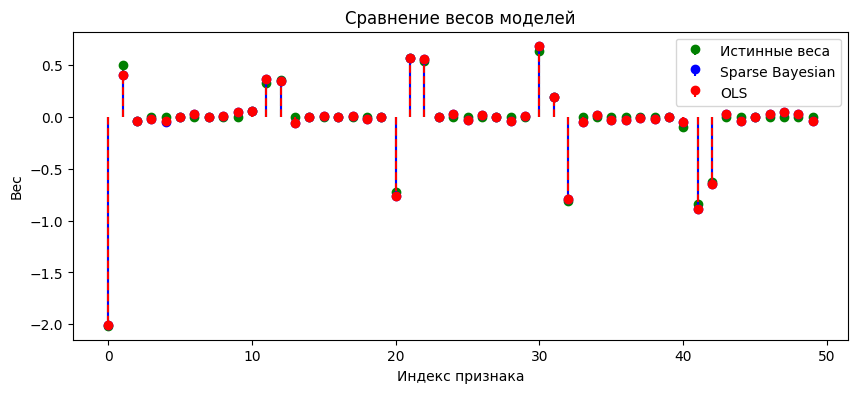

In [8]:
from matplotlib import pyplot as plt
# Визуализация весов
plt.figure(figsize=(10,4))
plt.stem(true_w.reshape(-1).numpy(), linefmt='g-', markerfmt='go', basefmt=' ', label='Истинные веса')
plt.stem(sbr._get_flat_params().cpu().detach().numpy(), linefmt='b-', markerfmt='bo', basefmt=' ', label='Sparse Bayesian')
plt.stem(ols.weight.detach().cpu().numpy().flatten(), linefmt='r--', markerfmt='ro', basefmt=' ', label='OLS')
plt.legend()
plt.title('Сравнение весов моделей')
plt.xlabel('Индекс признака')
plt.ylabel('Вес')
plt.show()

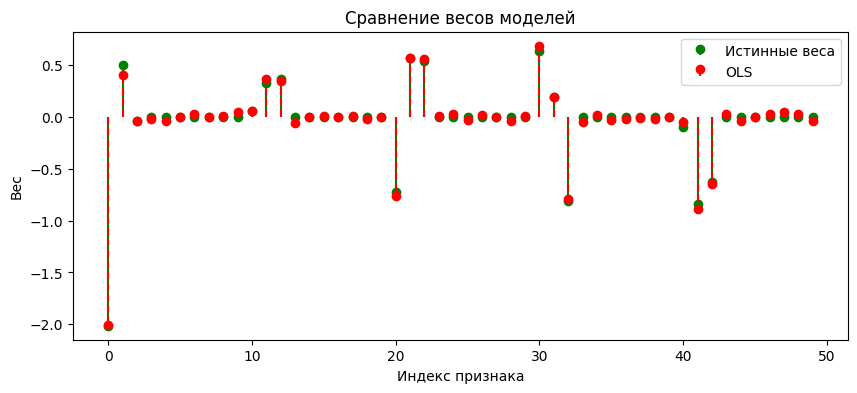

In [9]:
from matplotlib import pyplot as plt
# Визуализация весов
plt.figure(figsize=(10,4))
plt.stem(true_w.reshape(-1).numpy(), linefmt='g-', markerfmt='go', basefmt=' ', label='Истинные веса')
plt.stem(ols.weight.detach().cpu().numpy().flatten(), linefmt='r--', markerfmt='ro', basefmt=' ', label='OLS')
plt.legend()
plt.title('Сравнение весов моделей')
plt.xlabel('Индекс признака')
plt.ylabel('Вес')
plt.show()

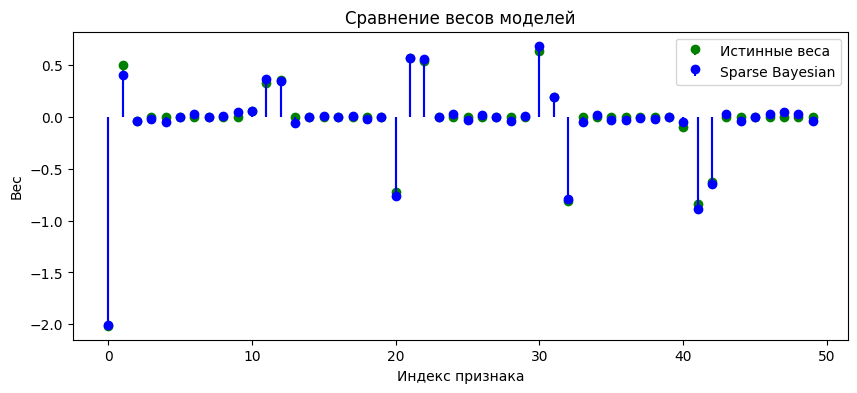

In [10]:
from matplotlib import pyplot as plt
# Визуализация весов
plt.figure(figsize=(10,4))
plt.stem(true_w.reshape(-1).numpy(), linefmt='g-', markerfmt='go', basefmt=' ', label='Истинные веса')
plt.stem(sbr._get_flat_params().cpu().detach().numpy(), linefmt='b-', markerfmt='bo', basefmt=' ', label='Sparse Bayesian')
plt.legend()
plt.title('Сравнение весов моделей')
plt.xlabel('Индекс признака')
plt.ylabel('Вес')
plt.show()

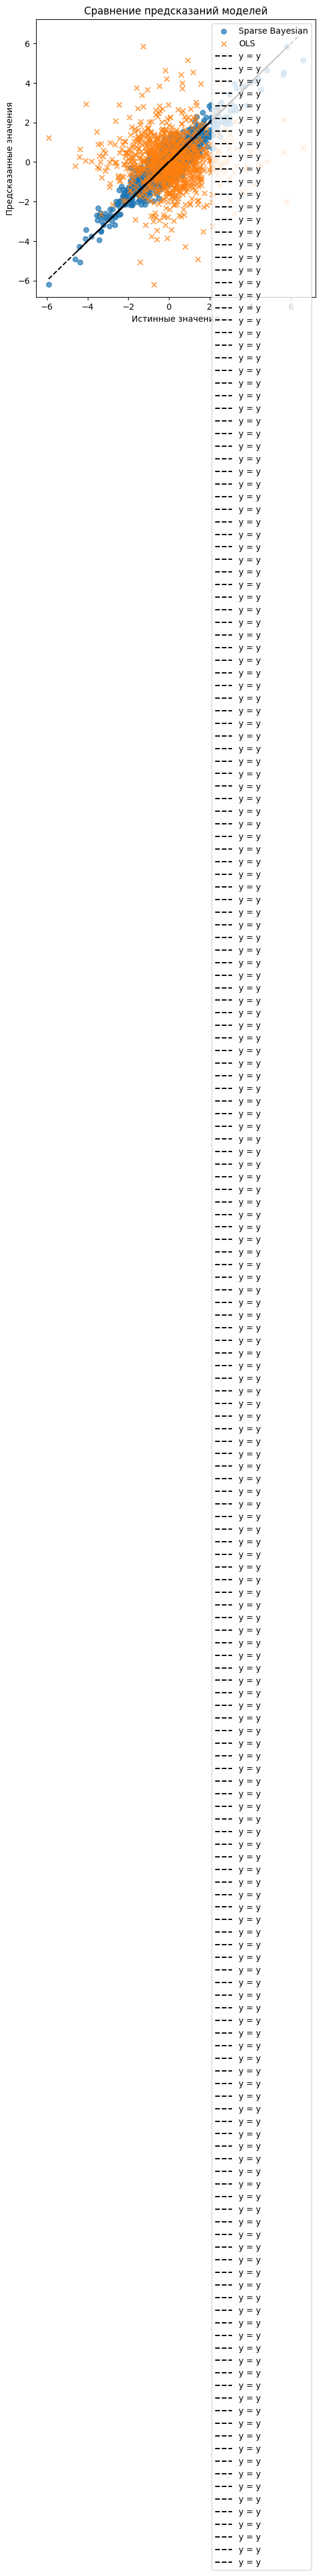

In [12]:
# Визуализация предсказаний
plt.figure(figsize=(6,6))
plt.scatter(Y.detach().numpy(), y_pred_sbr.detach().numpy(), alpha=0.7, label='Sparse Bayesian')
plt.scatter(Y.detach().numpy(), y_pred_ols.detach().numpy(), alpha=0.7, label='OLS', marker='x')
plt.plot(Y.detach().numpy(), Y.detach().numpy(), 'k--', label='y = y')
plt.xlabel('Истинные значения')
plt.ylabel('Предсказанные значения')
plt.legend()
plt.title('Сравнение предсказаний моделей')
plt.show()